# Analog Methods

## Setup

First, let's import the necessary libraries.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from skdownscale.pointwise_models import AnalogRegression, PureAnalog

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')

## Step 1: Load Climate Data

We'll use the same test dataset as in the BCSD tutorial. This includes:
- **Training data**: Coarse-resolution climate model output
- **Target data**: High-resolution observations

In [30]:
# Define the training period
training_time_slice = slice('1980', '2001')

# Load data from cloud storage
data = xr.open_datatree(
    's3://carbonplan/share/scikit-downscale/test-data.zarr',
    engine='zarr',
    chunks={},
    storage_options={'anon': True, 'endpoint_url': 'https://rice1.osn.mghpcc.org'},
)

# Extract training and target datasets
training = data['training'].to_dataset().sel(time=training_time_slice)
targets = data['targets'].to_dataset().sel(time=training_time_slice)

print('Training data:')
display(training)
print('\nTarget data:')
display(targets)

Training data:


<xarray.Dataset> Size: 2MB
Dimensions:      (point: 5, time: 8036)
Coordinates:
  * time         (time) datetime64[ns] 64kB 1980-01-01T11:30:00 ... 2001-12-3...
    lat          (point) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
    lon          (point) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: point
Data variables: (12/15)
    DIV          (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_ACC_C   (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_ACC_NC  (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_TOT     (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PSFC         (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    QVAPOR       (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    ...           ...
    T2min        (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    T_MEAN       (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    T_RANGE      (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    U            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    V            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    W            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
Attributes:
    NCO:                        "4.5.5"
    history:                    Wed Mar  1 13:48:35 2017: ncatted -a calendar...
    history_of_appended_files:  Wed Feb  8 14:15:52 2017: Appended file wrf_d...
    nco_openmp_thread_number:   1


Target data:


<xarray.Dataset> Size: 707kB
Dimensions:  (time: 8036, point: 5)
Coordinates:
  * time     (time) datetime64[ns] 64kB 1980-01-01 1980-01-02 ... 2001-12-31
    lat      (point) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    lon      (point) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: point
Data variables:
    Prec     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    Tmax     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    Tmin     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    wind     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    CDO:                       Climate Data Operators version 1.6.4 (http://c...
    Conventions:               CF-1.4
    NCO:                       4.4.5
    history:                   Fri Oct 10 17:54:37 2014: cdo ifthenelse /Volu...
    nco_openmp_thread_number:  1

## Step 2: Prepare Data for a Single Location

We'll extract temperature and precipitation data for a single point and convert units appropriately.

In [31]:
# Extract temperature data (convert Kelvin to Celsius)
X_temp = training.isel(point=0).to_dataframe()[['T2max']] - 273.15
y_temp = targets.isel(point=0).to_dataframe()[['Tmax']]

# Extract precipitation data (convert to mm/day)
X_pcp = training.isel(point=0).to_dataframe()[['PREC_TOT']] * 24
y_pcp = targets.isel(point=0).to_dataframe()[['Prec']]

print('Training temperature (first 5 days):')
display(X_temp.head())
print('\nTarget temperature (first 5 days):')
display(y_temp.head())

Training temperature (first 5 days):


,T2max
time,
1980-01-01 11:30:00,7.229950
1980-01-02 11:30:00,6.005737
1980-01-03 11:30:00,4.625702
1980-01-04 11:30:00,3.686951
1980-01-05 11:30:00,1.733826



Target temperature (first 5 days):


,Tmax
time,
1980-01-01,7.24
1980-01-02,7.16
1980-01-03,6.53
1980-01-04,4.46
1980-01-05,1.78


## Step 3: Understanding Analog Selection Strategies

The `PureAnalog` class supports four different strategies for selecting and using analog days:

### 1. Best Analog
- Selects the single closest analog day
- Fastest and simplest approach
- Can be deterministic (always same result)

### 2. Sample Analogs
- Randomly samples from the N best analogs
- Adds stochasticity to the predictions
- Good for ensemble generation

### 3. Weight Analogs
- Uses a weighted average of N analogs
- Weights based on similarity (closer analogs get more weight)
- Smooths out predictions

### 4. Mean Analogs
- Simple average of N best analogs
- Equal weight to all selected analogs
- Balances simplicity and robustness

Let's compare these strategies on temperature data.

## Step 4: Apply Different Analog Strategies

We'll split our data into training and testing periods, then compare the four analog strategies.

In [32]:
# Split data: first 1000 days for training, rest for testing
train_size = 1000
X_train, X_test = X_temp[:train_size], X_temp[train_size:]
y_train, y_test = y_temp[:train_size], y_temp[train_size:]

print(f'Training period: {X_train.index[0]} to {X_train.index[-1]}')
print(f'Testing period: {X_test.index[0]} to {X_test.index[-1]}')
print(f'\nTraining samples: {len(X_train)}')
print(f'Testing samples: {len(X_test)}')

Training period: 1980-01-01 11:30:00 to 1982-09-26 11:30:00
Testing period: 1982-09-27 11:30:00 to 2001-12-31 11:31:00

Training samples: 1000
Testing samples: 7036


In [33]:
# Dictionary to store results (clear any previous results)
results = {}

# Test each analog strategy
strategies = ['best_analog', 'sample_analogs', 'weight_analogs', 'mean_analogs']
n_analogs = 10  # Number of analogs to consider

for strategy in strategies:
    print(f'\nFitting {strategy}...')

    # Initialize and fit the model
    model = PureAnalog(kind=strategy, n_analogs=n_analogs)
    model.fit(X_train, y_train)

    # Generate predictions (extract only the 'pred' column)
    predictions_full = model.predict(X_test)
    predictions = predictions_full[['pred']]  # Keep only prediction column
    results[strategy] = predictions

    # Calculate simple performance metric (RMSE)
    rmse = np.sqrt(np.mean((predictions.values - y_test.values) ** 2))
    print(f'  RMSE: {rmse:.3f}°C')

print('\nAll strategies fitted successfully!')


Fitting best_analog...
  RMSE: 3.066°C

Fitting sample_analogs...
  RMSE: 3.066°C

Fitting weight_analogs...
  RMSE: 2.481°C

Fitting mean_analogs...
  RMSE: 2.322°C

All strategies fitted successfully!


/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/pyth

## Step 5: Visualize Results

Let's compare the predictions from different strategies by plotting a 300-day sample.

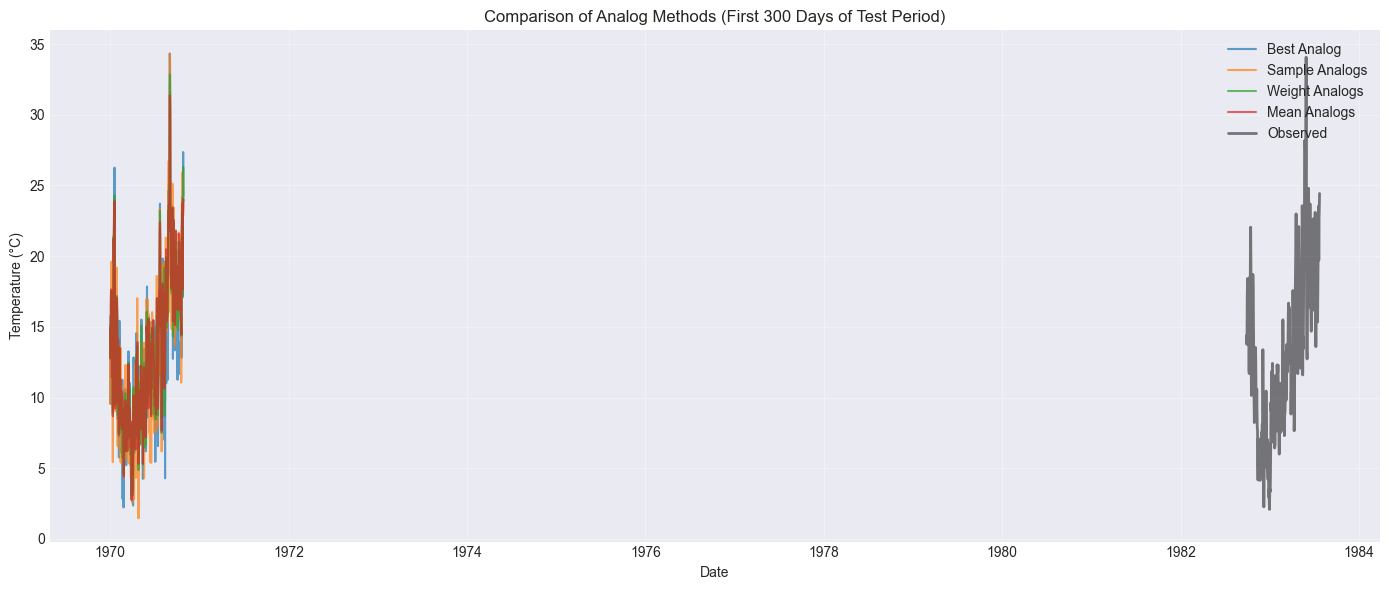

In [34]:
# Plot predictions for the first 300 days of test period
plot_days = 300

fig, ax = plt.subplots(figsize=(14, 6))

# Plot each strategy
for strategy, predictions in results.items():
    ax.plot(
        predictions.index[:plot_days],
        predictions.values[:plot_days],
        label=strategy.replace('_', ' ').title(),
        alpha=0.7,
        linewidth=1.5,
    )

# Plot observations
ax.plot(
    y_test.index[:plot_days],
    y_test.values[:plot_days],
    label='Observed',
    color='black',
    linewidth=2,
    alpha=0.5,
)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Comparison of Analog Methods (First 300 Days of Test Period)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Observations

From the plot, you'll notice:
- **Best Analog**: Can be quite variable, following individual historical days
- **Sample Analogs**: Similar to best analog but with randomness
- **Weight Analogs**: Smoother predictions due to weighted averaging
- **Mean Analogs**: Also smooth, using equal weights

The averaging approaches (weight and mean) tend to be more stable but may miss some variability.

## Step 6: Analog Regression

`AnalogRegression` combines the analog method with linear regression:
1. Find N analog days
2. Fit a linear regression using those analog days
3. Apply the regression to make predictions

This hybrid approach can capture both the analog similarity and systematic relationships.

In [35]:
# Initialize and fit AnalogRegression
n_analogs_reg = 100  # Use more analogs for regression

print(f'Fitting AnalogRegression with {n_analogs_reg} analogs...')
analog_reg = AnalogRegression(n_analogs=n_analogs_reg)
analog_reg.fit(X_train, y_train)

# Generate predictions (extract only the 'pred' column)
predictions_reg_full = analog_reg.predict(X_test)
predictions_reg = predictions_reg_full[['pred']]  # Keep only prediction column

# Calculate RMSE
rmse_reg = np.sqrt(np.mean((predictions_reg.values - y_test.values) ** 2))
print(f'AnalogRegression RMSE: {rmse_reg:.3f}°C')

Fitting AnalogRegression with 100 analogs...


/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AnalogRegression RMSE: 2.247°C


## Step 7: Compare All Methods

Let's create a comprehensive comparison including AnalogRegression.

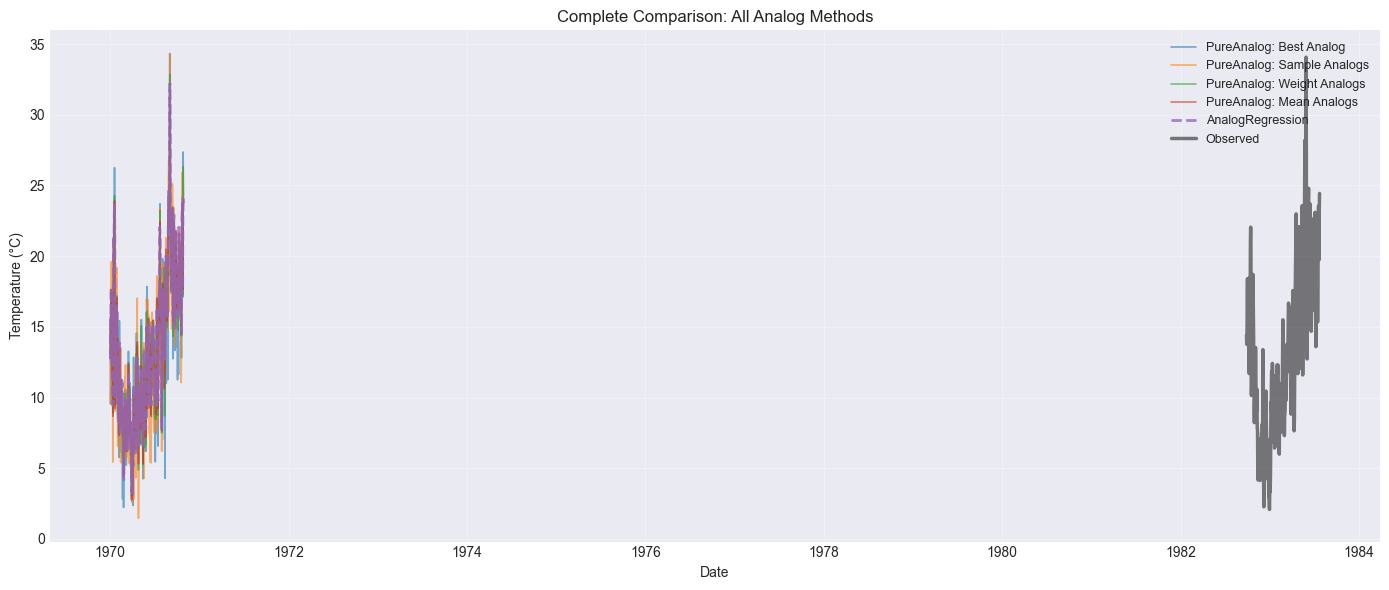

In [36]:
# Plot all methods including AnalogRegression
fig, ax = plt.subplots(figsize=(14, 6))

# Plot PureAnalog strategies
for strategy, predictions in results.items():
    ax.plot(
        predictions.index[:plot_days],
        predictions.values[:plot_days],
        label=f'PureAnalog: {strategy.replace("_", " ").title()}',
        alpha=0.6,
        linewidth=1.2,
    )

# Plot AnalogRegression
ax.plot(
    predictions_reg.index[:plot_days],
    predictions_reg.values[:plot_days],
    label='AnalogRegression',
    linewidth=2,
    alpha=0.8,
    linestyle='--',
)

# Plot observations
ax.plot(
    y_test.index[:plot_days],
    y_test.values[:plot_days],
    label='Observed',
    color='black',
    linewidth=2.5,
    alpha=0.5,
)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Complete Comparison: All Analog Methods')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 8: Quantitative Performance Comparison

Let's calculate multiple performance metrics to better understand each method.

In [37]:
import pandas as pd


def calculate_metrics(predictions, observations):
    """Calculate RMSE, MAE, and correlation coefficient."""
    pred_vals = predictions.values.flatten()
    obs_vals = observations.values.flatten()

    rmse = np.sqrt(np.mean((pred_vals - obs_vals) ** 2))
    mae = np.mean(np.abs(pred_vals - obs_vals))
    corr = np.corrcoef(pred_vals, obs_vals)[0, 1]

    return {'RMSE': rmse, 'MAE': mae, 'Correlation': corr}


# Calculate metrics for all methods
metrics_data = []

for strategy, predictions in results.items():
    metrics = calculate_metrics(predictions, y_test)
    metrics['Method'] = f'PureAnalog ({strategy})'
    metrics_data.append(metrics)

# Add AnalogRegression metrics
metrics_reg = calculate_metrics(predictions_reg, y_test)
metrics_reg['Method'] = 'AnalogRegression'
metrics_data.append(metrics_reg)

# Create comparison table
metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df[['Method', 'RMSE', 'MAE', 'Correlation']]
metrics_df = metrics_df.round(3)

print('\nPerformance Comparison:')
print('=' * 60)
display(metrics_df)


Performance Comparison:


,Method,RMSE,MAE,Correlation
0,PureAnalog (best_analog),3.066,2.358,0.906
1,PureAnalog (sample_analogs),3.066,2.368,0.906
2,PureAnalog (weight_analogs),2.481,1.883,0.938
3,PureAnalog (mean_analogs),2.322,1.747,0.946
4,AnalogRegression,2.247,1.684,0.950


## Step 9: Scatter Plots for Visual Assessment

Scatter plots help visualize the relationship between predictions and observations.

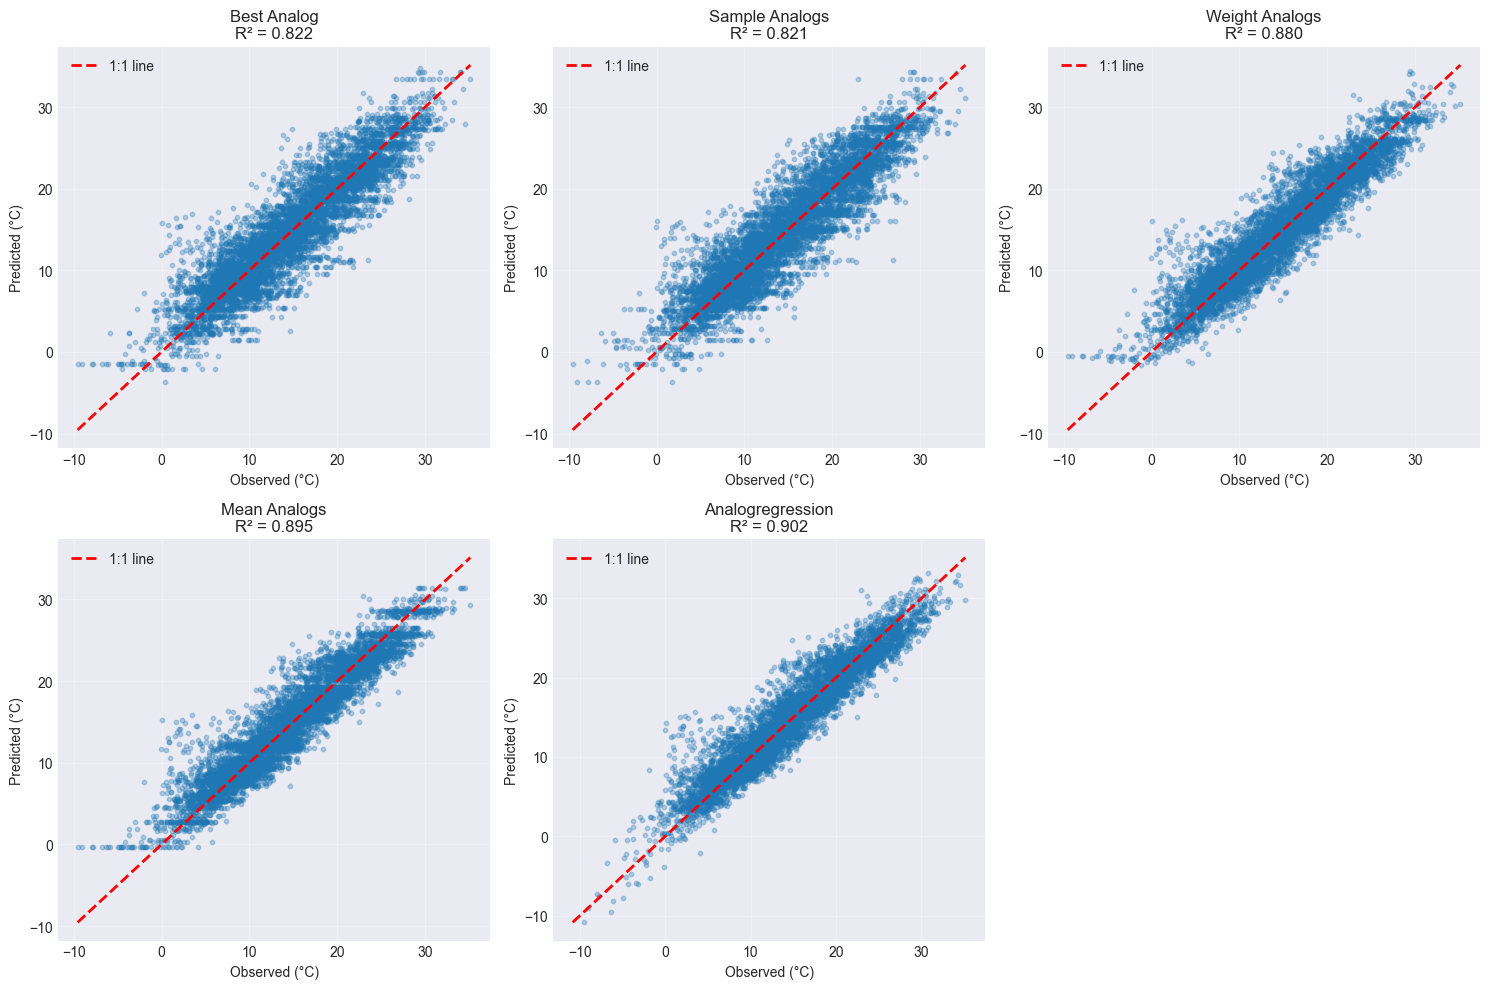

In [38]:
# Create scatter plots for each method
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

all_methods = {**results, 'AnalogRegression': predictions_reg}

for idx, (method_name, predictions) in enumerate(all_methods.items()):
    ax = axes[idx]

    # Scatter plot
    ax.scatter(y_test.values, predictions.values, alpha=0.3, s=10)

    # Add 1:1 line
    min_val = min(y_test.values.min(), predictions.values.min())
    max_val = max(y_test.values.max(), predictions.values.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 line')

    # Calculate and display R²
    corr = np.corrcoef(y_test.values.flatten(), predictions.values.flatten())[0, 1]
    r_squared = corr**2

    ax.set_xlabel('Observed (°C)')
    ax.set_ylabel('Predicted (°C)')
    ax.set_title(f'{method_name.replace("_", " ").title()}\nR² = {r_squared:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Summary

In this tutorial, we explored analog methods for statistical downscaling:

### Key Concepts

1. **Analog Methods** find similar historical weather patterns to make predictions
2. **PureAnalog** offers four strategies:
   - `best_analog`: Single closest match
   - `sample_analogs`: Random selection from top N
   - `weight_analogs`: Weighted average by similarity
   - `mean_analogs`: Simple average of top N
3. **AnalogRegression** combines analog selection with linear regression

### Performance Trade-offs

- **Best/Sample Analogs**: More variability, can capture extremes
- **Weighted/Mean Analogs**: Smoother, more stable predictions
- **AnalogRegression**: Balances analog similarity with systematic relationships

### When to Use Analog Methods

Analog methods are particularly useful when:
- Relationships are complex and non-linear
- Preserving realistic weather patterns is important
- You have a good historical record of observations
- Downscaling multiple related variables simultaneously

### Next Steps

- Try analog methods on precipitation data
- Experiment with different numbers of analogs
- Apply to multiple spatial points using `PointWiseDownscaler`
- Compare analog methods with BCSD on the same dataset
- Explore GARD (Generalized Analog Regression Downscaling) for more advanced applications

### References

- Gutmann, E. D., et al. (2014). An intercomparison of statistical downscaling methods. *Journal of Climate*, 27(23), 8903-8924.
- Zorita, E., & von Storch, H. (1999). The analog method as a simple statistical downscaling technique. *Journal of Climate*, 12(8), 2474-2489.